In [6]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np


import jax
import jax.numpy as jnp
from jax import nn as jax_nn
from jax.config import config; config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=32) 
from jax import jacfwd, jacrev
from jax import grad as jax_grad

import torch
import torch.nn as nn
from torch.autograd import Variable

from copy import deepcopy

!pip install nlopt
import nlopt

from utils.datasets import construct_toy_dataset
from utils.utils import TheoremChecker, find_closest_neurons
from utils.models import TeacherNetwork, DummyNetwork
from utils.training import train_second_order
from utils.jax_helpers import jax_loss, jax_grad

In [7]:
D_in, H_teacher, H_student, D_out = 2, 4, 5, 1
dataset, labels = construct_toy_dataset()
tensor_dataset, tensor_labels = torch.DoubleTensor(dataset), torch.DoubleTensor(labels)

teacher_model = TeacherNetwork()
y_labels = teacher_model(tensor_dataset).detach()

In [8]:
data = pd.read_csv('experiments_data_student_5_local_min_only.csv', float_precision='round_trip')
len(data)

426

In [53]:
data['loss'][:30]

0     0.000114
1     0.000084
2     0.000098
3     0.000100
4     0.000084
5     0.000115
6     0.000114
7     0.000102
8     0.000114
9     0.000081
10    0.000077
11    0.000050
12    0.000062
13    0.000115
14    0.000077
15    0.000069
16    0.000080
17    0.000114
18    0.000077
19    0.000072
20    0.000073
21    0.000105
22    0.000076
23    0.000073
24    0.000076
25    0.000084
26    0.000077
27    0.000084
28    0.000073
29    0.000116
Name: loss, dtype: float64

In [67]:
data.loc[5]['loss']

0.00011474520184703572

In [76]:
def extract_weights(data_point):
  incoming_weights_x = []
  incoming_weights_y = []
  outgoing_weights = []

  for i in range(0, int(data_point['student size'])):
    neuron_traj_x = np.fromstring(data_point['neuron_' + str(i) + '_traj_x'][1:-1], dtype=float, sep=',')
    neuron_traj_y = np.fromstring(data_point['neuron_' + str(i) + '_traj_y'][1:-1], dtype=float, sep=',')
    incoming_weights_x.append(neuron_traj_x[-1])
    incoming_weights_y.append(neuron_traj_y[-1])
    neuron_traj_out = np.fromstring(data_point['neuron_' + str(i) + '_a'][1:-1], dtype=float, sep=',')
    outgoing_weights.append(neuron_traj_out[-1])

  return incoming_weights_x, incoming_weights_y, outgoing_weights

def construct_si_saddle(final_weights, mu):
    num_neurons = int(len(final_weights) / 3)
    w_in_torch_format = torch.DoubleTensor(final_weights[0 : num_neurons * 2].reshape(num_neurons, 2))
    w_out_torch_format = torch.DoubleTensor([final_weights[num_neurons * 2 :].reshape(num_neurons)])

    si_saddle = np.array([])
    teacher_idx = 1

    for i in range(H_student):
      if i == idx_neuron1 or i == idx_neuron2:
        si_saddle = np.append(si_saddle, w_in_torch_format[0][0].item())
        si_saddle = np.append(si_saddle, w_in_torch_format[0][1].item())
        continue
      si_saddle = np.append(si_saddle, w_in_torch_format[teacher_idx][0].item())
      si_saddle = np.append(si_saddle, w_in_torch_format[teacher_idx][1].item())
      teacher_idx += 1

    teacher_idx = 1

    for i in range(H_student):
      if i == idx_neuron1:
        si_saddle = np.append(si_saddle,
                              mu * w_out_torch_format[0][0].item())
        continue
      if i == idx_neuron2:
        si_saddle = np.append(si_saddle,
                              (1 - mu) * w_out_torch_format[0][0].item())
        continue
      si_saddle = np.append(si_saddle,
                            w_out_torch_format[0][teacher_idx].item())
      teacher_idx += 1

    return si_saddle

def find_saddle_line(final_weights):
    saddle_smallest_u = construct_si_saddle(final_weights, -1)
    saddle_largest_u = construct_si_saddle(final_weights, 2)
    
    saddle_line_dir = (saddle_largest_u - saddle_smallest_u) / \
                       np.linalg.norm(saddle_largest_u - saddle_smallest_u)
    closest_saddle = saddle_smallest_u + saddle_line_dir * \
                     np.dot(saddle_line_dir, (local_min - saddle_smallest_u))
    optimal_mu = closest_saddle[2 * H_student + idx_neuron1] / final_weights[2 * H_teacher]
    directional_vector = local_min - closest_saddle
    
    return closest_saddle, optimal_mu, directional_vector

In [82]:
%load_ext autoreload
%autoreload 2

theorem_checker = TheoremChecker(D_in, H_teacher, D_out)
dists = []

for idx, data_point in data.iterrows():
    # if idx != 5:
    #     continue
    # if idx == 20:
    #     break
    incoming_weights_x, incoming_weights_y, outgoing_weights = extract_weights(data_point)
    local_min = np.array([incoming_weights_x[0], incoming_weights_y[0],
                 incoming_weights_x[1], incoming_weights_y[1],
                 incoming_weights_x[2], incoming_weights_y[2],
                 incoming_weights_x[3], incoming_weights_y[3],
                 incoming_weights_x[4], incoming_weights_y[4],
                 outgoing_weights[0], outgoing_weights[1], outgoing_weights[2],
                 outgoing_weights[3], outgoing_weights[4]])
    
    w_in = np.array([[incoming_weights_x[0], incoming_weights_y[0]],
                      [incoming_weights_x[1], incoming_weights_y[1]],
                      [incoming_weights_x[2], incoming_weights_y[2]],
                      [incoming_weights_x[3], incoming_weights_y[3]],
                      [incoming_weights_x[4], incoming_weights_y[4]]], dtype=np.float64)
    w_out = np.array([outgoing_weights], dtype=np.float64)
    
    idx_neuron1, idx_neuron2 = find_closest_neurons(w_in)
    
    new_incoming_weights_x = [(incoming_weights_x[idx_neuron1] + \
                               incoming_weights_x[idx_neuron2]) / 2.0]
    new_incoming_weights_y = [(incoming_weights_y[idx_neuron1] + \
                               incoming_weights_y[idx_neuron2]) / 2.0]
    new_outgoing_weights = [(outgoing_weights[idx_neuron1] + \
                             outgoing_weights[idx_neuron2])]
    
    network_size = len(w_in)

    for i in range(network_size):
      if i == idx_neuron1 or i == idx_neuron2:
        continue
      new_incoming_weights_x.append(incoming_weights_x[i])
      new_incoming_weights_y.append(incoming_weights_y[i])
      new_outgoing_weights.append(outgoing_weights[i])
    
    new_w_in = torch.DoubleTensor([[new_incoming_weights_x[0], new_incoming_weights_y[0]],
                           [new_incoming_weights_x[1], new_incoming_weights_y[1]],
                           [new_incoming_weights_x[2], new_incoming_weights_y[2]],
                           [new_incoming_weights_x[3], new_incoming_weights_y[3]]])
    new_w_out = torch.DoubleTensor([new_outgoing_weights])
    dummy_model = DummyNetwork(D_in, H_teacher, D_out, new_w_in, new_w_out)
    
    final_weights = train_second_order(dummy_model)
    
    closest_saddle, optimal_mu, _ = find_saddle_line(final_weights)
    
    Y, U = theorem_checker.check_si_saddle_failure_mode(final_weights)

    evals, _ = jnp.linalg.eigh(optimal_mu * (1 - optimal_mu) * Y)
    if evals[0] >= 0:
        dists.append(jnp.linalg.norm(closest_saddle - local_min))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
dists = np.array(dists)
dists = dists[dists < 0.1]

Text(0, 0.5, 'Number of data points')

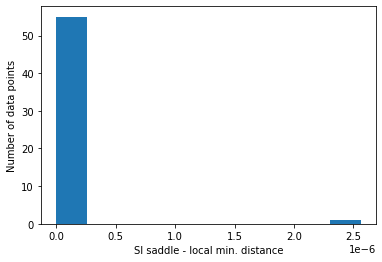

In [102]:
plt.hist(dists)
plt.xlabel('SI saddle - local min. distance')
plt.ylabel('Number of data points')

In [99]:
len(dists) / len(data)

0.13145539906103287